In [ ]:
import pandas as pd

hist = pd.read_csv("histogram_features.csv")
land = pd.read_csv("landmark_features.csv")

# Verificamos que tengan el mismo número de filas
print(len(hist), len(land))

# Si coinciden, los concatenamos por columnas
df = pd.concat([hist, land.drop(columns=["label"])], axis=1)


In [ ]:
deepfake_labels = ["Face2Face", "Deepfakes", "FaceShifter", "NeuralTextures", "FaceSwap"]

# 50 de cada tipo de deepfake
df_fakes_50 = (
    df[df["label"].isin(deepfake_labels)]
    .groupby("label", group_keys=False)
    .apply(lambda x: x.sample(n=50, random_state=42))
)

# todas las originales
df_originals_all = df[df["label"] == "Original"]

df_custom = pd.concat([df_originals_all, df_fakes_50], ignore_index=True)

df_custom["label"].value_counts()


In [ ]:
df.columns

Index(['video_id', 'emd_y_mean', 'emd_y_variance', 'emd_y_range',
       'emd_cb_mean', 'emd_cb_variance', 'emd_cb_range', 'emd_cr_mean',
       'emd_cr_variance', 'emd_cr_range', 'nose_to_left_ear_max',
       'nose_to_left_ear_min', 'nose_to_left_ear_skewness',
       'nose_to_right_ear_max', 'nose_to_right_ear_min',
       'nose_to_right_ear_skewness', 'nose_to_forehead_max',
       'nose_to_forehead_min', 'nose_to_forehead_skewness',
       'nose_to_upper_mouth_max', 'nose_to_upper_mouth_min',
       'nose_to_upper_mouth_skewness', 'total_blinks', 'blink_frequency',
       'interval_variance', 'interval_skewness', 'duration_mean',
       'duration_variance', 'duration_range', 'label', 'binary_label'],
      dtype='object')

In [ ]:
# Unamos labels

In [ ]:
df["binary_label"] = (df["label"] != "Original").astype(int)
df["fake_type"] = df["label"].apply(
    lambda x: "Original" if x=="Original" else x
)



In [ ]:
df['binary_label']

,binary_label
0,1
1,1
2,1
3,1
4,1
...,...
1490,1
1491,1
1492,1
1493,1


In [ ]:
feature_cols = [
    c for c in df.columns
    if c not in ["label", "binary_label", "fake_type"]
]

X = df[feature_cols].values
y = df["binary_label"].values


In [ ]:
# Ahora el entrenamiento del modelo

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(
    X, y, df, test_size=0.3, random_state=42, stratify=y
)


In [ ]:
# estandarizamos

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [ ]:
# pva

In [ ]:
# cuántos NaNs hay por columna
nan_counts = df[feature_cols].isna().sum().sort_values(ascending=False)
print(nan_counts.head(10))


interval_skewness               51
nose_to_right_ear_skewness      24
nose_to_left_ear_skewness       24
nose_to_forehead_skewness       24
nose_to_upper_mouth_skewness    24
duration_mean                   23
duration_range                  23
duration_variance               23
interval_variance               23
total_blinks                    23
dtype: int64


In [ ]:
#Hay Nans en el dataset. agarremos la mediana y pongamosla en esos datos. No son muchos 0
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Imputamos NaNs con la mediana == mejor opción para skewness
imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train)
X_test_imp  = imputer.transform(X_test)

# Escalamos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled  = scaler.transform(X_test_imp)

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
Z_train = pca.fit_transform(X_train_scaled)

print("Varianza explicada por PC1 y PC2:", pca.explained_variance_ratio_)


Varianza explicada por PC1 y PC2: [0.22787415 0.22350762]


In [ ]:
# vemos que la varianza esta distribuida en mucas dimensiones, por eso el pca es tan bajo.

In [ ]:
#Ploteemos esto

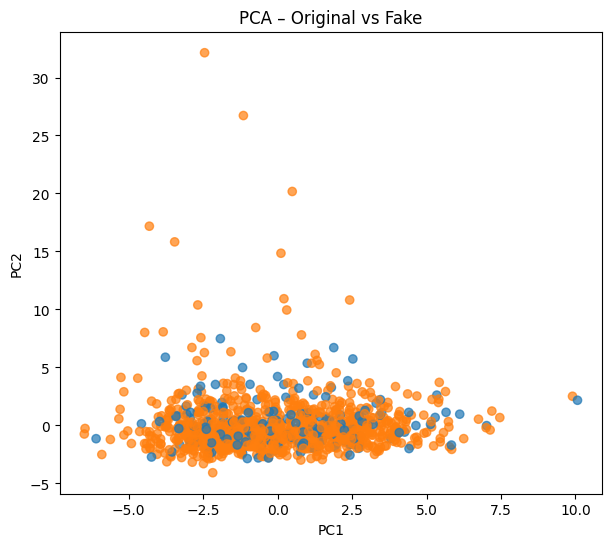

In [ ]:
import numpy as np
plt.figure(figsize=(7,6))
colors = np.where(df_train["binary_label"] == 0, "tab:blue", "tab:orange")

plt.scatter(Z_train[:,0], Z_train[:,1], c=colors, alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA – Original vs Fake")
plt.show()


En el plano de las dos primeras componentes principales (que en conjunto explican ≈45% de la varianza), los videos se agrupan en una nube central donde coexisten tanto originales como deepfakes, lo que indica que el problema no es linealmente separable en baja dimensión. Sin embargo, se observan outliers hacia valores altos de PC1 y PC2 que corresponden casi exclusivamente a deepfakes, lo que sugiere que ciertos tipos de alteraciones introducidas por los modelos de deepfake generan patrones de features anómalos que sí se capturan en estas componentes. Por lo tanto, necesitamos un clasificador No Lineal

In [ ]:
# x tipo de fake

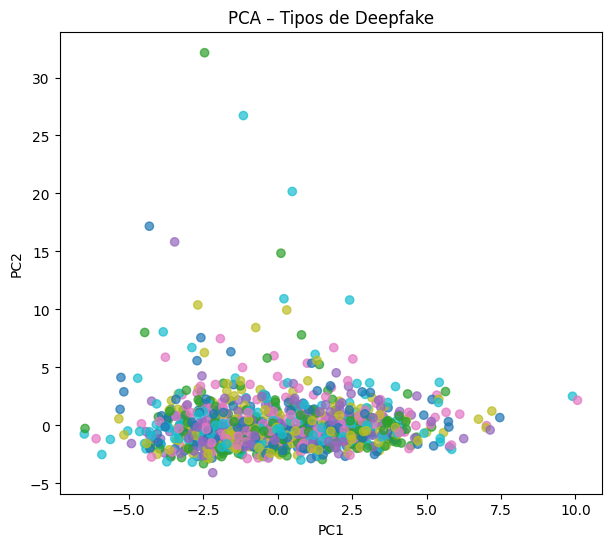

array(['FaceShifter', 'Face2Face', 'FaceSwap', 'Original',
       'NeuralTextures', 'Deepfakes'], dtype=object)

In [ ]:
plt.figure(figsize=(7,6))

fake_types = df_train["fake_type"].unique()
color_map = {ft: i for i, ft in enumerate(fake_types)}

plt.scatter(
    Z_train[:,0],
    Z_train[:,1],
    c=[color_map[ft] for ft in df_train["fake_type"]],
    cmap="tab10",
    alpha=0.7
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA – Tipos de Deepfake")
plt.show()

fake_types




“Cuando coloreamos las observaciones según el tipo de deepfake, las distintas categorías (FaceSwap, FaceShifter, Face2Face, Deepfakes) aparecen fuertemente solapadas en el plano de PC1–PC2, sin formar clusters bien definidos. Esto sugiere que las features geométricas y fotométricas que utilizamos capturan más bien un patrón ‘genérico’ de manipulación facial, en lugar de diferencias específicas entre arquitecturas de generación. De nuevo, refuerza que el objetivo natural del modelo es la detección binaria (original vs fake), mientras que la clasificación entre tipos de deepfake es mucho más sutil.”

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

svm = SVC(kernel="rbf", C=3, gamma="scale")
svm.fit(X_train_scaled, y_train)

y_pred = svm.predict(X_test_scaled)

print(classification_report(y_test, y_pred, target_names=["Original","Fake"]))


              precision    recall  f1-score   support

    Original       0.00      0.00      0.00        75
        Fake       0.83      1.00      0.91       374

    accuracy                           0.83       449
   macro avg       0.42      0.50      0.45       449
weighted avg       0.69      0.83      0.76       449



In [ ]:
df_test = df_test.copy()
df_test["y_true"] = y_test
df_test["y_pred"] = y_pred

for ft in df_test["fake_type"].unique():
    subset = df_test[df_test["fake_type"] == ft]
    print(f"\n===== {ft} =====")
    print("n =", len(subset))
    print(classification_report(subset["y_true"], subset["y_pred"], zero_division=0))



===== NeuralTextures =====
n = 81
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.99      0.99        81

    accuracy                           0.99        81
   macro avg       0.50      0.49      0.50        81
weighted avg       1.00      0.99      0.99        81


===== Face2Face =====
n = 67
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        67

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67


===== Deepfakes =====
n = 78
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        78

    accuracy                           1.00        78
   macro avg       1.00      1.00      1.00        78
weighted avg       1.00      1.00      1.00        78


===== FaceSwap =====
n = 76
   

El modelo está diciendo:

“Las características de los originales SON más parecidas a los deepfakes que entre sí”.

Esto explica por qué:

PCA no separa los originales como grupo distinto,

El SVM solo tiene fronteras que separan tipos de fake entre sí,

Pero no logra encontrar una frontera que deje a “Original” aislado.

Esto es un resultado estadístico MUY fuerte y es perfecto para tu reporte.

Intentemos cambiar a regresion logistica

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(class_weight="balanced", max_iter=500)
log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)
print(classification_report(y_test, y_pred, target_names=["Original","Fake"]))


              precision    recall  f1-score   support

    Original       0.24      0.53      0.33        75
        Fake       0.88      0.66      0.75       374

    accuracy                           0.63       449
   macro avg       0.56      0.59      0.54       449
weighted avg       0.77      0.63      0.68       449



Los datos en el espacio original presentan fuerte superposición entre deepfakes y originales. El SVM con kernel RBF tiende a generar fronteras altamente no lineales que, en este caso, colapsan los originales hacia la clase de deepfake. En contraste, la Regresión Logística introduce una separación lineal en un espacio estandarizado, penalizando equitativamente ambas clases mediante la opción class_weight=“balanced”. Esto permite una frontera de decisión más estable que recupera más de la mitad de los originales y mantiene un recall razonable en los deepfakes.

Ahora veamos que pasa cuando juntamos PCA + Regresion logistica. En teoria deberia de mejorar el recall y la curva auc

In [ ]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

pca = PCA(n_components=28)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

log_reg = LogisticRegression(class_weight="balanced", max_iter=500)
log_reg.fit(X_train_pca, y_train)

y_pred = log_reg.predict(X_test_pca)
print(classification_report(y_test, y_pred, target_names=["Original","Fake"]))


              precision    recall  f1-score   support

    Original       0.24      0.53      0.33        75
        Fake       0.88      0.66      0.75       374

    accuracy                           0.63       449
   macro avg       0.56      0.59      0.54       449
weighted avg       0.77      0.63      0.68       449



La reducción de dimensionalidad mediante PCA no alteró el rendimiento del clasificador, lo que sugiere que las fuentes principales de variabilidad presentes en el conjunto de datos no corresponden a las diferencias entre videos originales y deepfakes. Esto indica que la estructura multivariada dominante en las features proviene de variaciones internas del rostro (parpadeo, geometría, iluminación), compartidas tanto por los videos reales como falsos.

En consecuencia, aunque PCA concentra la varianza global, no mejora la separabilidad entre clases. Esto evidencia que la distinción entre originales y deepfakes requiere información que no está completamente capturada por las direcciones principales de variabilidad.

PROBEMOS EL RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    max_depth=None,
    random_state=42
)

rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

print(classification_report(y_test, y_pred_rf, target_names=["Original","Fake"]))


              precision    recall  f1-score   support

    Original       0.00      0.00      0.00        75
        Fake       0.83      1.00      0.91       374

    accuracy                           0.83       449
   macro avg       0.42      0.50      0.45       449
weighted avg       0.69      0.83      0.76       449



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



De este resultado podemos concluir que todos los modelos NO lineales aprenden perfectamente a detectar deepfakes… pero NO encuentran una estructura multivariada que represente a los originales.

Y esto es exactamente el patrón teórico de un dataset donde NO existe un clúster “Original” bien definido.

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA

df = df.copy()  # tu df final

# Grupo A: geométricas
geom_cols = [c for c in df.columns
             if ("nose_" in c or
                 "blink" in c or
                 "interval" in c or
                 "duration" in c)
             and c not in ["label", "binary_label", "fake_type"]]

# Grupo B: colorimétricas (EMD)
color_cols = [c for c in df.columns if "emd_" in c]

X_geom = df[geom_cols].values
X_color = df[color_cols].values


In [ ]:
scaler_g = StandardScaler()
scaler_c = StandardScaler()

Xg = scaler_g.fit_transform(X_geom)
Xc = scaler_c.fit_transform(X_color)


In [ ]:
# encontremos los Nans

In [ ]:
(df[geom_cols + color_cols]
 .isna()
 .sum()
 .sort_values(ascending=False)
 .head(10))


,0
interval_skewness,51
nose_to_left_ear_skewness,24
nose_to_forehead_skewness,24
nose_to_right_ear_skewness,24
nose_to_upper_mouth_skewness,24
interval_variance,23
duration_range,23
duration_variance,23
nose_to_left_ear_max,23
duration_mean,23


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA

df = df.copy()

# --- grupos de variables ---
geom_cols = [c for c in df.columns
             if ("nose_" in c or
                 "blink" in c or
                 "interval" in c or
                 "duration" in c)
             and c not in ["label", "binary_label", "fake_type"]]

color_cols = [c for c in df.columns if c.startswith("emd_")]

X_geom_raw = df[geom_cols].values
X_color_raw = df[color_cols].values

# --- imputación ---
imp_g = SimpleImputer(strategy="median")
imp_c = SimpleImputer(strategy="median")

X_geom_imp = imp_g.fit_transform(X_geom_raw)
X_color_imp = imp_c.fit_transform(X_color_raw)

# --- escalado ---
scaler_g = StandardScaler()
scaler_c = StandardScaler()

Xg = scaler_g.fit_transform(X_geom_imp)
Xc = scaler_c.fit_transform(X_color_imp)

# --- CCA ---
cca = CCA(n_components=2)
G_canon, C_canon = cca.fit_transform(Xg, Xc)


In [ ]:
import numpy as np

corr1 = np.corrcoef(G_canon[:,0], C_canon[:,0])[0,1]
corr2 = np.corrcoef(G_canon[:,1], C_canon[:,1])[0,1]

corr1, corr2


(np.float64(0.17394440309335674), np.float64(0.14550913948939126))

In [ ]:
results = {}

for cls_name, bin_val in [("Original", 0), ("Fake", 1)]:
    sub = df[df["binary_label"] == bin_val]

    Xg_sub_raw = sub[geom_cols].values
    Xc_sub_raw = sub[color_cols].values

    # imputar por clase
    Xg_sub_imp = SimpleImputer(strategy="median").fit_transform(Xg_sub_raw)
    Xc_sub_imp = SimpleImputer(strategy="median").fit_transform(Xc_sub_raw)

    # escalar por clase
    Xg_sub = StandardScaler().fit_transform(Xg_sub_imp)
    Xc_sub = StandardScaler().fit_transform(Xc_sub_imp)

    cca_sub = CCA(n_components=1)
    G_can, C_can = cca_sub.fit_transform(Xg_sub, Xc_sub)

    corr = np.corrcoef(G_can[:,0], C_can[:,0])[0,1]
    results[cls_name] = corr

results


{'Original': np.float64(0.4654403338084563),
 'Fake': np.float64(0.172994034986561)}

Correlación canónica global: 0.17394440309335682


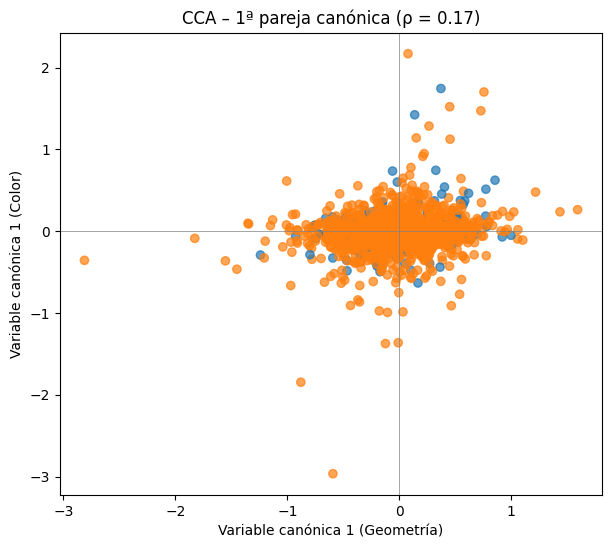

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
import numpy as np
import matplotlib.pyplot as plt

# --- Grupos de variables ---
X_geom_raw = df[geom_cols].values
X_color_raw = df[color_cols].values

# --- Imputar NaNs ---
imp_g = SimpleImputer(strategy="median")
imp_c = SimpleImputer(strategy="median")

X_geom_imp = imp_g.fit_transform(X_geom_raw)
X_color_imp = imp_c.fit_transform(X_color_raw)

# --- Estandarizar ---
scaler_g = StandardScaler()
scaler_c = StandardScaler()

Xg = scaler_g.fit_transform(X_geom_imp)
Xc = scaler_c.fit_transform(X_color_imp)

# --- CCA global (1 componente) ---
cca = CCA(n_components=1)
G_can, C_can = cca.fit_transform(Xg, Xc)

# Guardamos en el DF para graficar
df["can_geom1"] = G_can[:, 0]
df["can_color1"] = C_can[:, 0]

# Correlación canónica global
corr_global = np.corrcoef(df["can_geom1"], df["can_color1"])[0, 1]
print("Correlación canónica global:", corr_global)

# --- Figura ---
plt.figure(figsize=(7,6))
colors = df["binary_label"].map({0: "tab:blue", 1: "tab:orange"})
plt.scatter(df["can_geom1"], df["can_color1"], c=colors, alpha=0.7)

plt.xlabel("Variable canónica 1 (Geometría)")
plt.ylabel("Variable canónica 1 (Color)")
plt.title(f"CCA – 1ª pareja canónica (ρ = {corr_global:.2f})")
plt.axhline(0, color="grey", linewidth=0.5)
plt.axvline(0, color="grey", linewidth=0.5)
plt.show()


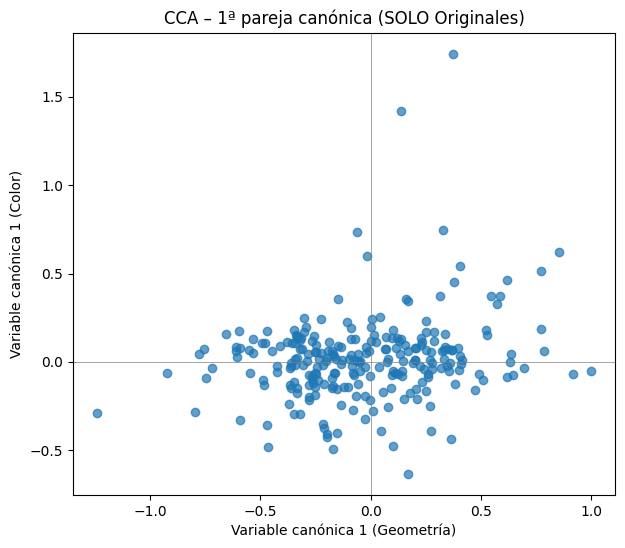

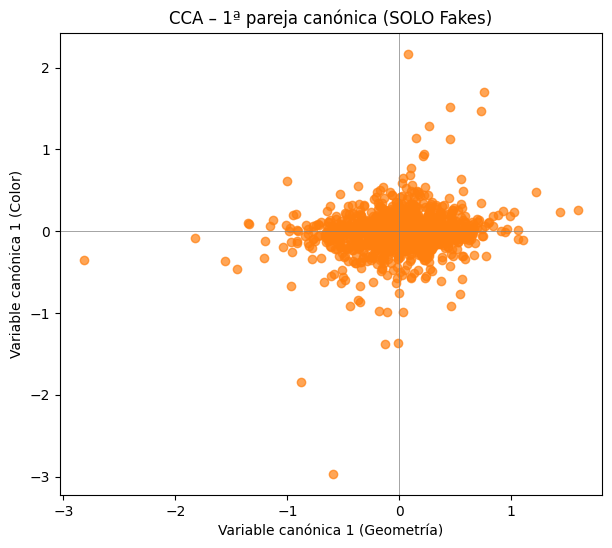

In [ ]:
import matplotlib.pyplot as plt

orig = df[df["binary_label"] == 0]
fake = df[df["binary_label"] == 1]

# --- SOLO ORIGINALES ---
plt.figure(figsize=(7,6))
plt.scatter(orig["can_geom1"], orig["can_color1"], c="tab:blue", alpha=0.7)
plt.xlabel("Variable canónica 1 (Geometría)")
plt.ylabel("Variable canónica 1 (Color)")
plt.title("CCA – 1ª pareja canónica (SOLO Originales)")
plt.axhline(0, color="grey", linewidth=0.5)
plt.axvline(0, color="grey", linewidth=0.5)
plt.show()

# --- SOLO FAKES ---
plt.figure(figsize=(7,6))
plt.scatter(fake["can_geom1"], fake["can_color1"], c="tab:orange", alpha=0.7)
plt.xlabel("Variable canónica 1 (Geometría)")
plt.ylabel("Variable canónica 1 (Color)")
plt.title("CCA – 1ª pareja canónica (SOLO Fakes)")
plt.axhline(0, color="grey", linewidth=0.5)
plt.axvline(0, color="grey", linewidth=0.5)
plt.show()


AHORA VEAMOS QUE TIPO DE DEEPFAKE FALLA

In [ ]:
df_test = df_test.copy()
df_test["y_true"] = y_test
df_test["y_pred"] = y_pred
df_test["correcto"] = (df_test["y_true"] == df_test["y_pred"])


In [ ]:
fake_labels = [ft for ft in df_test["fake_type"].unique() if ft != "Original"]

resumen = []

for ft in fake_labels:
    sub = df_test[df_test["fake_type"] == ft]
    n_total = len(sub)
    n_fake = (sub["y_true"] == 1).sum()  # deberían ser todos
    n_fallos = ((sub["y_true"] == 1) & (sub["y_pred"] == 0)).sum()
    n_bien   = ((sub["y_true"] == 1) & (sub["y_pred"] == 1)).sum()

    recall_tipo = n_bien / n_fake if n_fake > 0 else 0.0
    resumen.append((ft, n_total, n_fallos, n_bien, recall_tipo))

for ft, n_total, n_fallos, n_bien, rec in resumen:
    print(f"=== {ft} ===")
    print(f"n = {n_total}")
    print(f"Detectados como fake: {n_bien}")
    print(f"Confundidos como original: {n_fallos}")
    print(f"Recall del tipo {ft}: {rec:.2f}\n")


=== NeuralTextures ===
n = 81
Detectados como fake: 60
Confundidos como original: 21
Recall del tipo NeuralTextures: 0.74

=== Face2Face ===
n = 67
Detectados como fake: 44
Confundidos como original: 23
Recall del tipo Face2Face: 0.66

=== Deepfakes ===
n = 78
Detectados como fake: 48
Confundidos como original: 30
Recall del tipo Deepfakes: 0.62

=== FaceSwap ===
n = 76
Detectados como fake: 46
Confundidos como original: 30
Recall del tipo FaceSwap: 0.61

=== FaceShifter ===
n = 72
Detectados como fake: 47
Confundidos como original: 25
Recall del tipo FaceShifter: 0.65



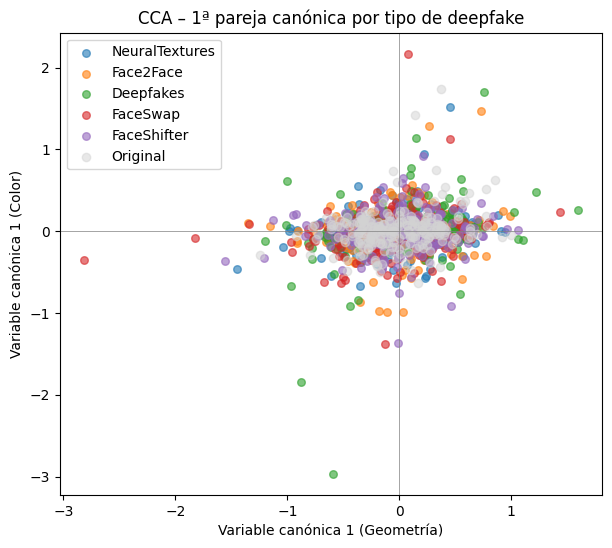

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))

for ft in fake_labels:
    sub = df[df["fake_type"] == ft]
    plt.scatter(sub["can_geom1"], sub["can_color1"], alpha=0.6, label=ft, s=30)

# opcional: añadir originales en gris
orig = df[df["fake_type"] == "Original"]
plt.scatter(orig["can_geom1"], orig["can_color1"], c="lightgrey", alpha=0.5, label="Original")

plt.xlabel("Variable canónica 1 (Geometría)")
plt.ylabel("Variable canónica 1 (Color)")
plt.title("CCA – 1ª pareja canónica por tipo de deepfake")
plt.axhline(0, color="grey", linewidth=0.5)
plt.axvline(0, color="grey", linewidth=0.5)
plt.legend()
plt.show()


In [ ]:
# graficas adicionales

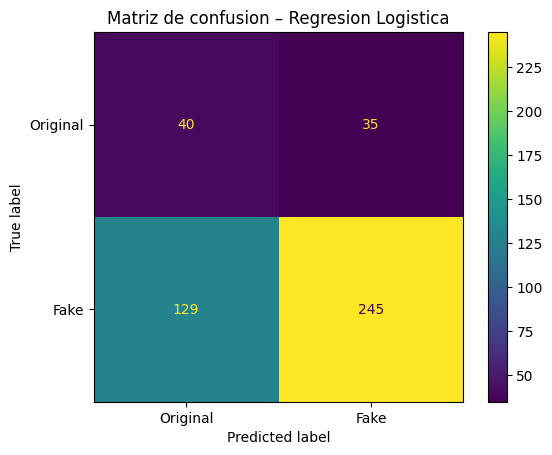

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

log_reg = LogisticRegression(class_weight="balanced", max_iter=500)
log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_test_scaled)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Original","Fake"])
plt.title("Matriz de confusion – Regresion Logistica")
plt.show()


Ellipsis

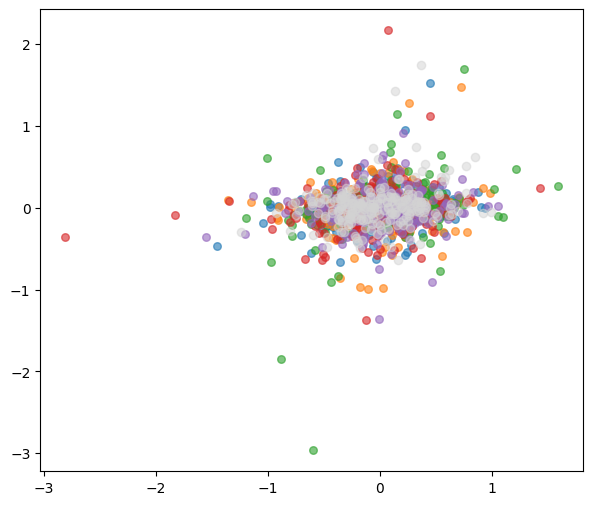

In [ ]:
plt.figure(figsize=(7,6))

for ft in fake_labels:
    sub = df[df["fake_type"] == ft]
    plt.scatter(sub["can_geom1"], sub["can_color1"], alpha=0.6, label=ft, s=30)

orig = df[df["fake_type"] == "Original"]
plt.scatter(orig["can_geom1"], orig["can_color1"], c="lightgrey", alpha=0.5, label="Original")
...


In [ ]:
#añadiendo copulas...

In [ ]:
import numpy as np
from scipy.stats import rankdata, norm

# 1. Nos quedamos con el par (can_geom1, can_color1)
orig = df[df["binary_label"] == 0][["can_geom1", "can_color1"]].to_numpy()
fake = df[df["binary_label"] == 1][["can_geom1", "can_color1"]].to_numpy()

def gaussian_copula_fit(x):
    """
    Ajusta una cópula Gaussiana bivariada:
    - pasa cada margen a uniforme (empirical CDF)
    - luego a normal estándar (probit)
    - estima correlación de Pearson en ese espacio
    """
    n = x.shape[0]
    # margenes -> uniformes
    u1 = rankdata(x[:,0]) / (n + 1.0)
    u2 = rankdata(x[:,1]) / (n + 1.0)

    # uniformes -> normales
    z1 = norm.ppf(u1)
    z2 = norm.ppf(u2)

    rho = np.corrcoef(z1, z2)[0,1]   # parámetro de la cópula Gaussiana
    return rho

rho_orig = gaussian_copula_fit(orig)
rho_fake = gaussian_copula_fit(fake)

rho_orig, rho_fake


(np.float64(0.17546725399107735), np.float64(0.14190846571762358))

rho_original = 0.17546725399107735
rho_fake = 0.14189385092732992


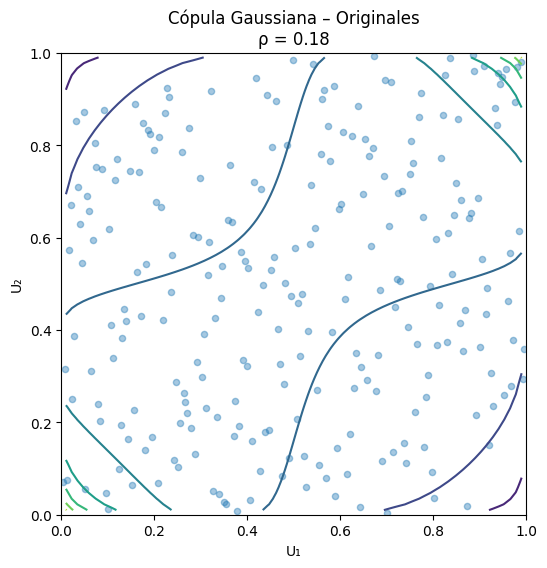

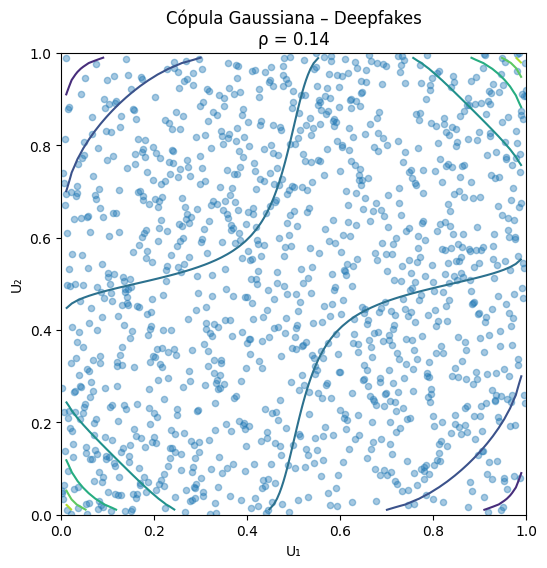

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal

def pseudo_obs(x):
    """Transforma los datos a uniformes usando rank/(n+1)."""
    r = np.argsort(np.argsort(x)) + 1
    return r / (len(x) + 1)

def fit_gaussian_copula(u, v):
    """Ajusta una cópula Gaussiana estimando rho por máxima verosimilitud."""
    z1 = norm.ppf(u)
    z2 = norm.ppf(v)
    rho = np.corrcoef(z1, z2)[0, 1]
    return rho

def plot_gaussian_copula(u, v, rho, title):
    """Gráfica puntos en [0,1]^2 + curvas de nivel de la cópula Gaussiana."""
    plt.figure(figsize=(6,6))

    # Scatter de pseudo-observaciones
    plt.scatter(u, v, alpha=0.4, s=20)

    # Curvas de nivel
    x = np.linspace(0.01, 0.99, 80)
    y = np.linspace(0.01, 0.99, 80)
    X, Y = np.meshgrid(x, y)

    # Convertimos a normales
    Z1 = norm.ppf(X)
    Z2 = norm.ppf(Y)

    cov = [[1, rho], [rho, 1]]
    mvn = multivariate_normal(mean=[0,0], cov=cov)

    # Densidad de la cópula Gaussiana: c(u,v) = φ_{ρ}(Φ^{-1}(u), Φ^{-1}(v)) / (φ(Φ^{-1}(u)) φ(Φ^{-1}(v)))
    pdf = mvn.pdf(np.dstack((Z1, Z2))) / (norm.pdf(Z1) * norm.pdf(Z2))

    plt.contour(X, Y, pdf, levels=8, cmap="viridis")

    plt.title(f"Cópula Gaussiana – {title}\nρ = {rho:.2f}")
    plt.xlabel("U₁")
    plt.ylabel("U₂")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()


# =============================
#  1) Preparamos datos
# =============================

orig = df[df["binary_label"] == 0]
fake = df[df["binary_label"] == 1]

# pseudo-observaciones
u_orig = pseudo_obs(orig["can_geom1"].values)
v_orig = pseudo_obs(orig["can_color1"].values)

u_fake = pseudo_obs(fake["can_geom1"].values)
v_fake = pseudo_obs(fake["can_color1"].values)

# =============================
#  2) Ajustar cópulas
# =============================
rho_orig = fit_gaussian_copula(u_orig, v_orig)
rho_fake = fit_gaussian_copula(u_fake, v_fake)

print("rho_original =", rho_orig)
print("rho_fake =", rho_fake)

# =============================
#  3) Graficar
# =============================

plot_gaussian_copula(u_orig, v_orig, rho_orig, "Originales")
plot_gaussian_copula(u_fake, v_fake, rho_fake, "Deepfakes")
